In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import binary_dilation
from skimage.segmentation import find_boundaries
from skimage.io import imsave
from skimage.measure import label, regionprops
from skimage import exposure
from czifile import imread
import torch
from huggingface_hub import hf_hub_download
from skimage.io import imsave
from cellpose import models 
model_cellpose = models.Cellpose(model_type='cyto')

from PIL import Image


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS = 25
pad = 5

out_dir = "images"
os.makedirs(os.path.join(out_dir, "solid"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "swiss_cheese"), exist_ok=True)

In [3]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image(image, title, path):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{title} {path}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def count(mask): 
    """Count the number of unique labels in the mask."""
    return len(np.unique(label(mask))) - 1  # Exclude background label (0)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

    return circular_mask, non_circular_mask
def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model_cellpose.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def find_swiss_cheese_inclusions(inclusion_image, red_channel_thresholded, verbose=False):

    """
    Identify and categorize inclusion objects based on their overlap with lipid droplets.
    - Labels individual inclusion objects in the binary inclusion image.
    - For each inclusion:
        - Checks whether it overlaps with the thresholded red channel (e.g., lipid droplets).
        - If it overlaps, adds it to the "swiss cheese" mask (inclusions with holes).
        - Otherwise, adds it to the "regular inclusion" mask (solid inclusions).
    - Returns two binary masks:
        - swiss_chess_inclusions: inclusions that intersect with the red channel
        - regular_inclusions: inclusions that do not intersect with the red channel
    """
    swiss_chess_inclusions = np.zeros_like(inclusion_image)
    regular_inclusions = np.zeros_like(inclusion_image)
    labeled_inclusions = label(inclusion_image)
    for i, inclusion in enumerate(regionprops(labeled_inclusions)):
        mask = labeled_inclusions == inclusion.label
        overlap = mask * red_channel_thresholded
        if np.sum(overlap) > 30:
            swiss_chess_inclusions += mask
        else:
            regular_inclusions += mask
    return swiss_chess_inclusions, regular_inclusions


def remove_overlapping_objects(mask1, mask2):

    # Label mask1 if it's not already labeled
    labeled_mask1 = label(mask1)
    result_mask = np.zeros_like(mask1, dtype=np.uint8)

    for region in regionprops(labeled_mask1):
        obj_mask = (labeled_mask1 == region.label)

        # Check if it overlaps with mask2
        if np.any(obj_mask & (mask2 > 0)):
            continue  # Skip overlapping object
        else:
            result_mask[obj_mask] = 1  # Keep the non-overlapping object

    return result_mask

def extract_touching_objects(mask1, mask2):
    """
    Return a mask containing whole objects in mask1
    that touch mask2.
    """
    touching_objects = np.zeros_like(mask1, dtype=np.uint8)

    labeled_mask = label(mask1)

    for region in regionprops(labeled_mask):
        region_mask = (labeled_mask == region.label)
        overlap = region_mask * mask2

        if np.sum(overlap) > 0:
            touching_objects += region_mask

    return touching_objects

def count_touching_objects(mask1, mask2):
    """
    Count how many objects in mask1 touch any part of mask2.

    Parameters:
        mask1 (ndarray): Binary or labeled mask (objects to test).
        mask2 (ndarray): Binary mask (objects to touch against).

    Returns:
        int: Number of objects in mask1 that touch mask2.
    """
    # Ensure binary input
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    labeled_mask1 = label(mask1)
    count = 0

    for region in regionprops(labeled_mask1):
        obj_mask = labeled_mask1 == region.label
        if np.any(obj_mask & mask2):
            count += 1

    return count

def expand_slice(slc, pad, shape):
    """Expand a slice by `pad` pixels in each direction, clipped to image shape."""
    new_slices = []
    for s, dim in zip(slc, shape):
        start = max(s.start - pad, 0)
        stop = min(s.stop + pad, dim)
        new_slices.append(slice(start, stop))
    return tuple(new_slices)


def to_rgb01(img):
    """Normalize grayscale to [0,1] and stack to RGB."""
    img = img.astype(np.float32)
    rng = img.max() - img.min()
    img01 = (img - img.min()) / (rng + 1e-8)
    return np.dstack([img01, img01, img01])

def overlay_color(base_img, mask, color=(1.0, 0.0, 0.0), alpha=0.4, draw_edges=True):
    """
    Overlay a binary `mask` onto `base_img` (grayscale or RGB) with given `color` and `alpha`.
    Returns RGB float image in [0,1].
    """
    if base_img.ndim == 2:
        out = to_rgb01(base_img)
    else:
        # assume already RGB or RGBA; convert to RGB float [0,1]
        arr = base_img.astype(np.float32)
        if arr.max() > 1.0: arr /= 255.0
        out = arr[..., :3].copy()

    color = np.array(color, dtype=np.float32).reshape(1, 1, 3)
    mask = mask.astype(bool)

    out[mask] = (1 - alpha) * out[mask] + alpha * color

    if draw_edges:
        edges = find_boundaries(mask, mode='outer')
        out[edges] = np.array([1.0, 1.0, 1.0], dtype=np.float32)  # white edge for clarity
    return out


def pad_to_square(img, target_size=128):
    """Pad a 2D grayscale image to a fixed square size centered."""
    h, w = img.shape
    # clip if larger than target (just in case)
    if h > target_size or w > target_size:
        raise ValueError(f"Crop {h}x{w} is bigger than target {target_size}")
    
    # how much padding needed
    pad_h = target_size - h
    pad_w = target_size - w
    
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    
    padded = np.pad(img, ((top, bottom), (left, right)), mode='constant', constant_values=0)
    return padded

In [4]:
def analysis(green: np.ndarray, red: np.ndarray, file_name: str):
    """
    GREEN-only features; no skimage.feature usage.
    Splits into Swiss (1 in mask window) vs Solid, returns (df_swiss, df_solid).
    """
    # normalize filename and load mask
    if ".czi" in file_name:
        file_name = file_name.replace(".czi", "")
    image_path = os.path.join(os.getcwd(), "masks", file_name + "_green.png")
    mask_gray = np.array(Image.open(image_path).convert("L"))

    labeled = label(mask_gray > 0)
    rows_swiss, rows_solid = [], []

    for props in regionprops(labeled):
        green_crop  = green[props.slice]
        region_mask = props.image  # boolean mask for this region

        # --- shape/geometry ---
        area                = props.area
        bbox_area           = props.bbox_area
        extent              = props.extent
        perimeter           = getattr(props, "perimeter", np.nan)
        convex_area         = getattr(props, "convex_area", np.nan)
        solidity            = getattr(props, "solidity", np.nan)
        eccentricity        = getattr(props, "eccentricity", np.nan)
        equiv_diameter      = getattr(props, "equivalent_diameter", np.nan)
        major_axis_length   = getattr(props, "major_axis_length", np.nan)
        minor_axis_length   = getattr(props, "minor_axis_length", np.nan)
        orientation         = getattr(props, "orientation", np.nan)
        filled_area         = getattr(props, "filled_area", np.nan)
        euler_number        = getattr(props, "euler_number", np.nan)
        holes_count         = 1 - euler_number if np.isfinite(euler_number) else np.nan

        # --- intensity stats (green) ---
        g_vals = green_crop[region_mask]
        if g_vals.size:
            g_mean   = float(np.mean(g_vals))
            g_std    = float(np.std(g_vals, ddof=0))
            g_median = float(np.median(g_vals))
            g_min    = float(np.min(g_vals))
            g_max    = float(np.max(g_vals))
            g_range  = g_max - g_min
            g_cv     = (g_std / g_mean) if g_mean != 0 else np.nan  # coefficient of variation
            # lightweight texture-ish summaries (no GLCM)
            smoothness = 1 - 1 / (1 + g_std**2)
            p = g_vals / np.sum(g_vals)  # normalized histogram proxy
            uniformity = float(np.sum(p**2))
        else:
            g_mean=g_std=g_median=g_min=g_max=g_range=g_cv=smoothness=uniformity=np.nan

        # --- swiss vs solid by your rule ---
        unique_vals = np.unique(mask_gray[props.slice])
        unique_vals = unique_vals[unique_vals != 0]
        is_swiss = 1 in unique_vals

        # keep your displays
        if is_swiss:
            display_image(green_crop, "Swiss Cheese Inclusion", file_name)
        else:
            display_image(green_crop, "Solid Inclusion", file_name)

        row = {
            "file_name": file_name,
            "region_label": int(props.label),
            # geometry
            "area": area, "bbox_area": bbox_area, "extent": extent, "perimeter": perimeter,
            "convex_area": convex_area, "solidity": solidity, "eccentricity": eccentricity,
            "equivalent_diameter": equiv_diameter, "major_axis_length": major_axis_length,
            "minor_axis_length": minor_axis_length, "orientation": orientation,
            "filled_area": filled_area, "euler_number": euler_number, "holes_count": holes_count,
            # intensity
            "green_mean": g_mean, "green_std": g_std, "green_median": g_median,
            "green_min": g_min, "green_max": g_max, "green_range": g_range, "green_cv": g_cv,
            # simple texture-ish
            "smoothness": smoothness, "uniformity": uniformity,
        }

        (rows_swiss if is_swiss else rows_solid).append(row)

    df_swiss = pd.DataFrame(rows_swiss).sort_values(["file_name","region_label"]).reset_index(drop=True)
    df_solid = pd.DataFrame(rows_solid).sort_values(["file_name","region_label"]).reset_index(drop=True)
    return df_swiss, df_solid

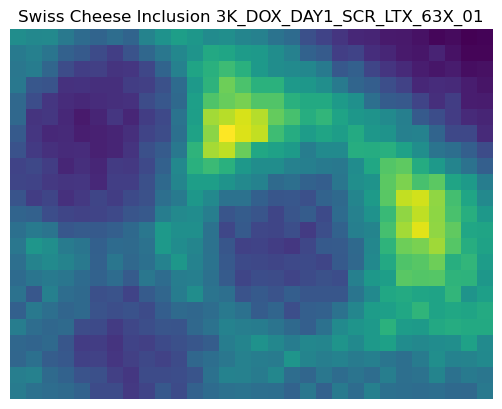

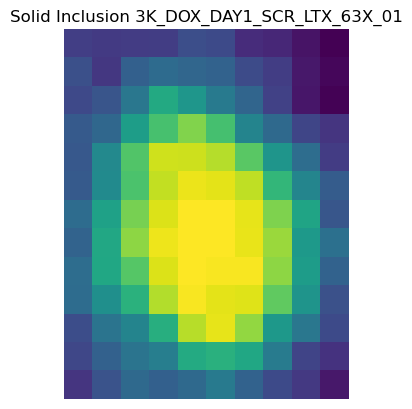

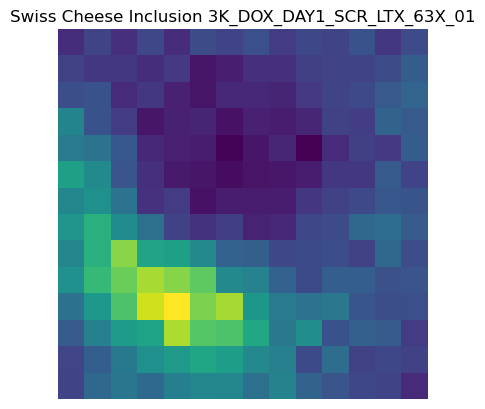

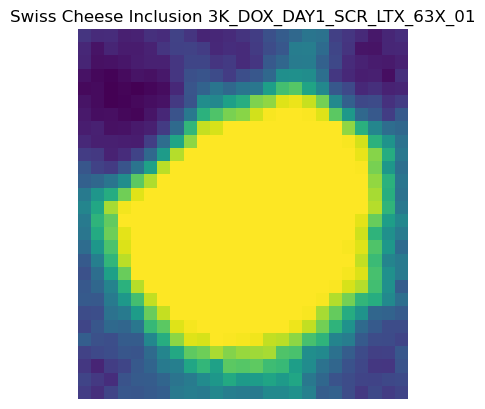

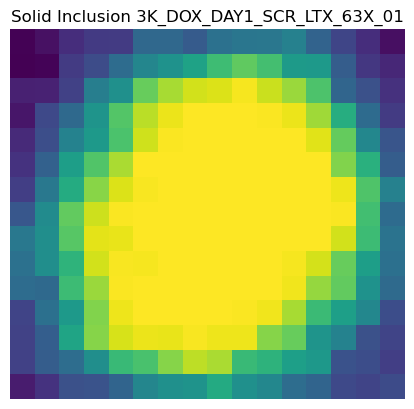

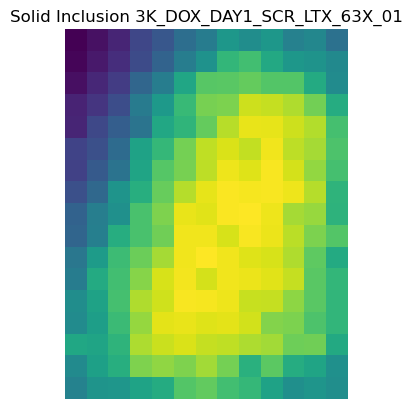

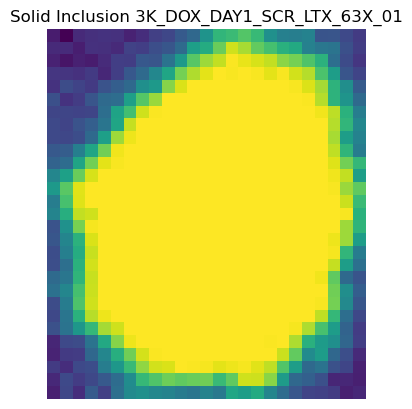

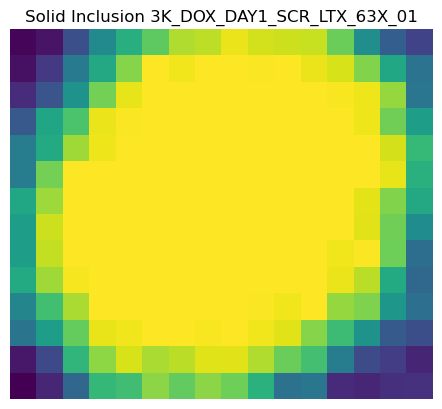

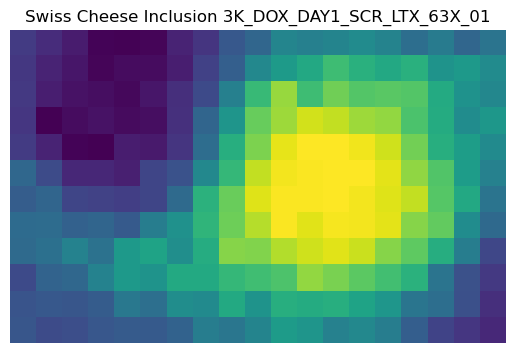

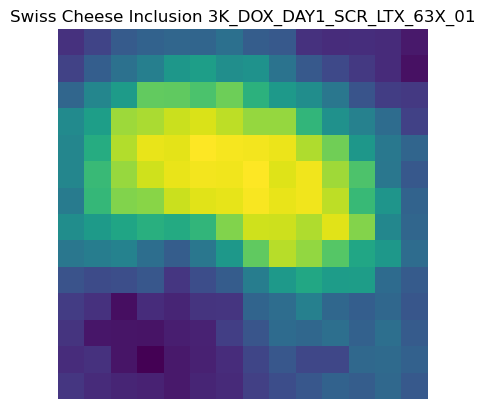

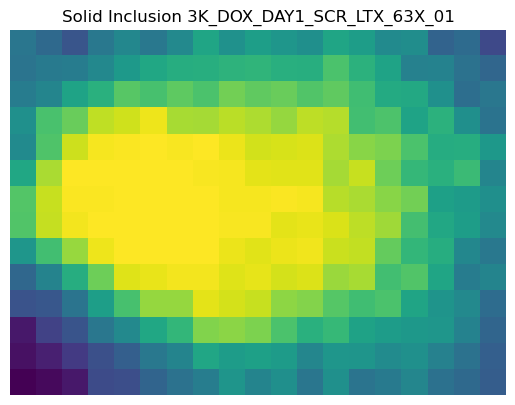

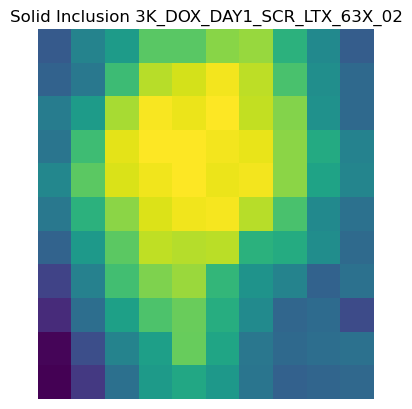

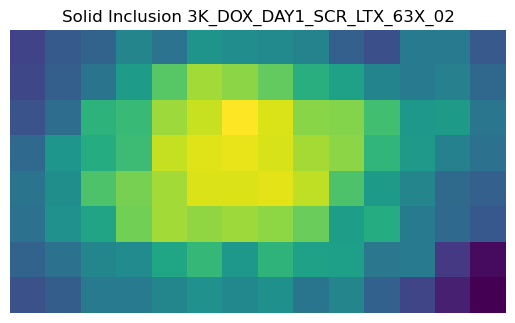

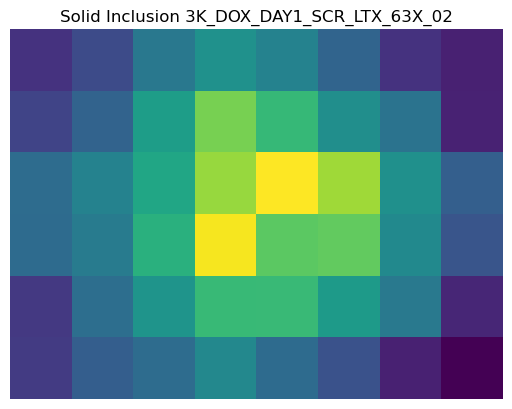

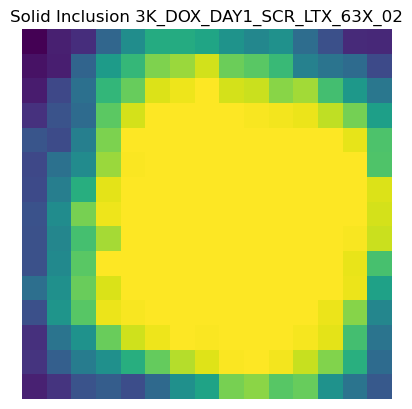

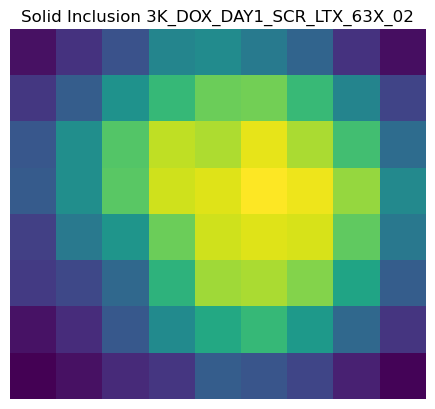

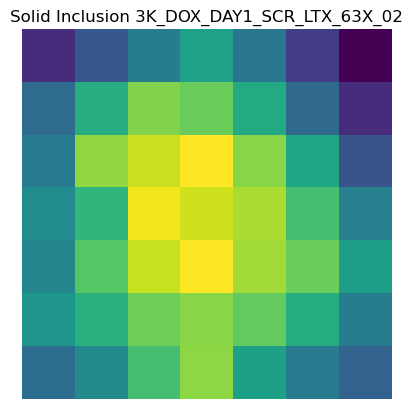

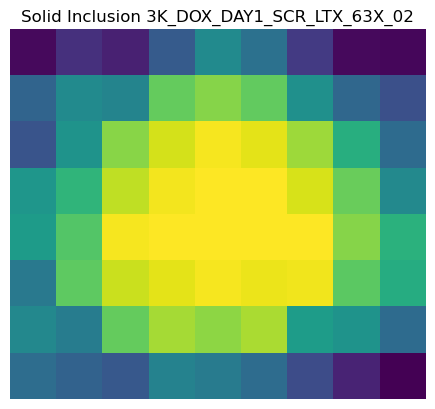

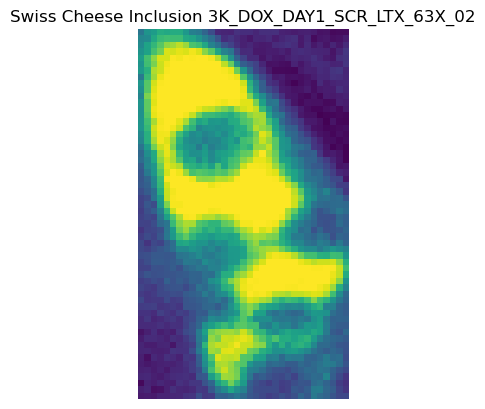

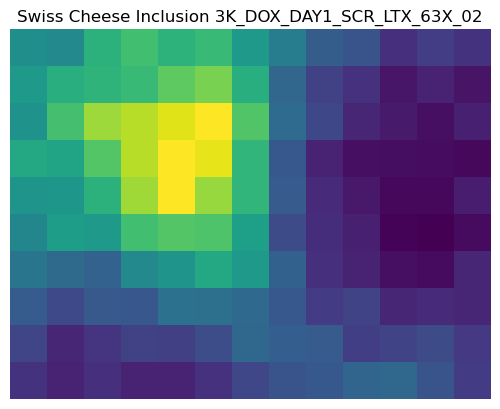

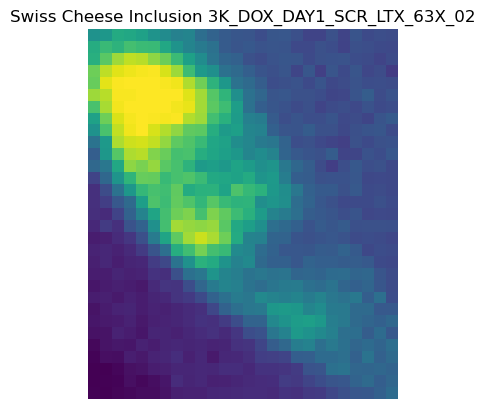

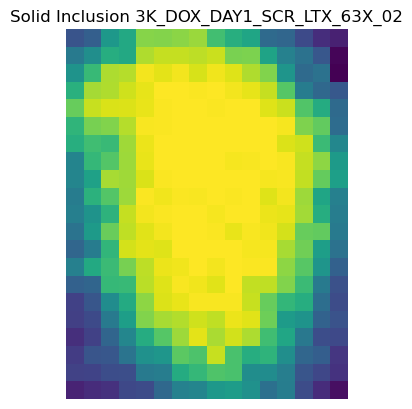

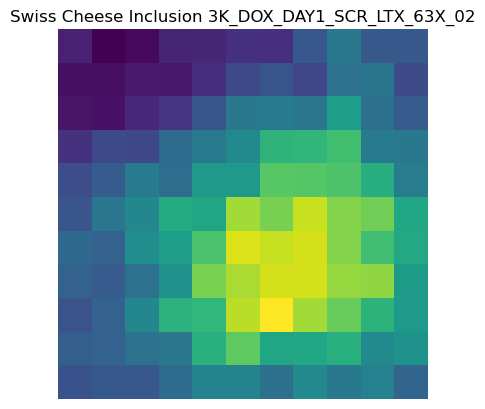

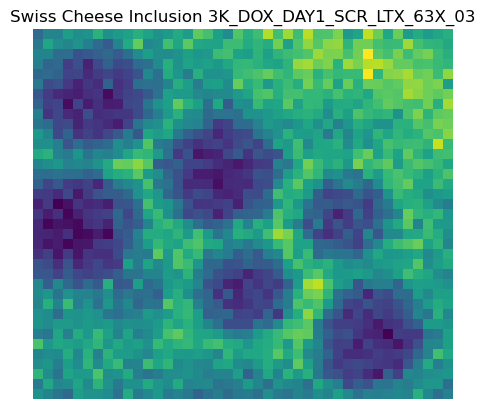

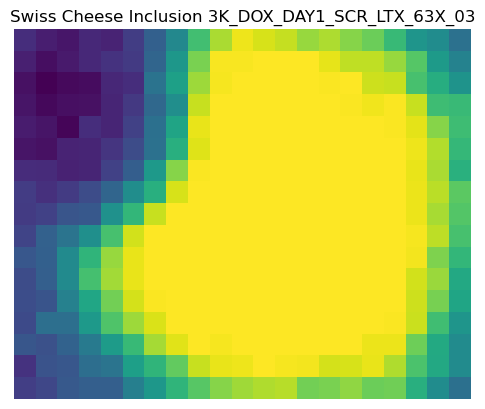

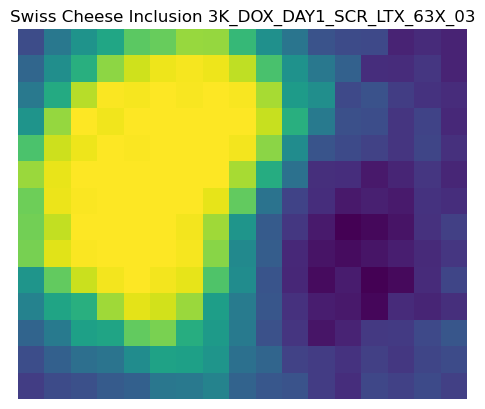

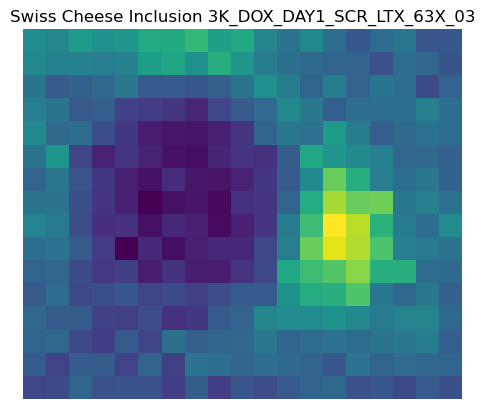

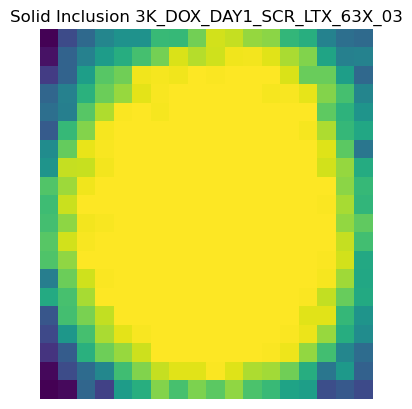

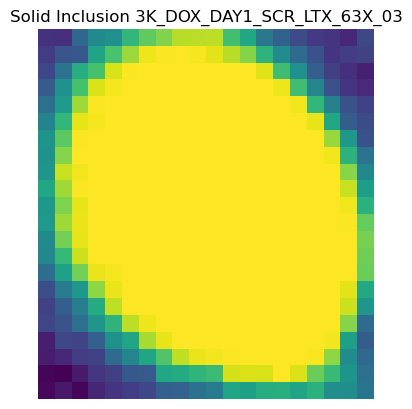

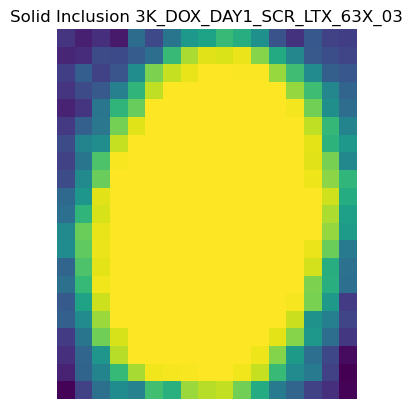

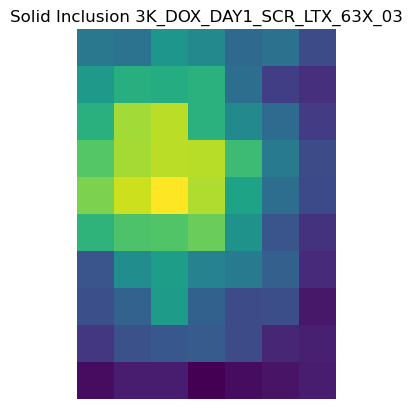

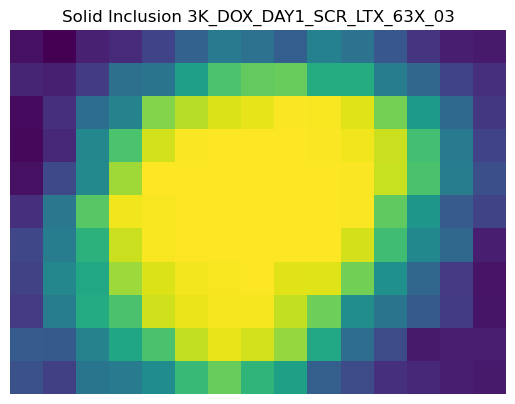

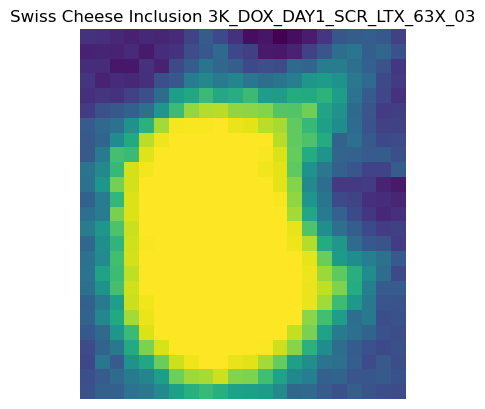

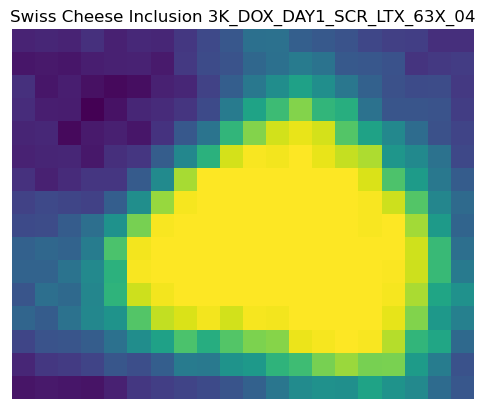

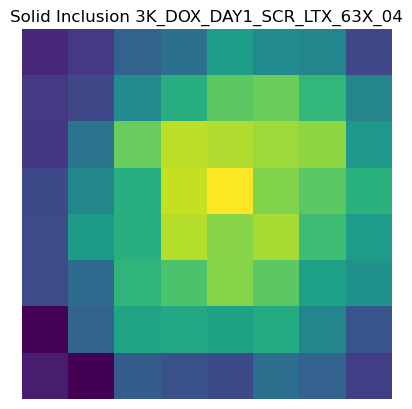

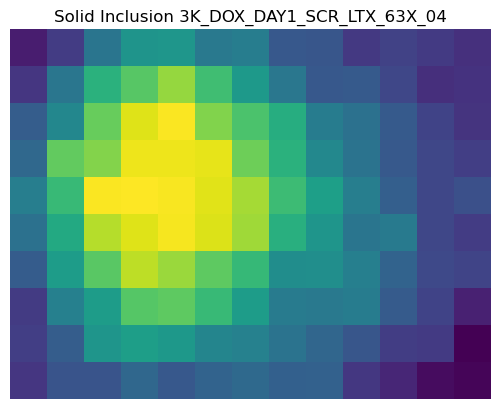

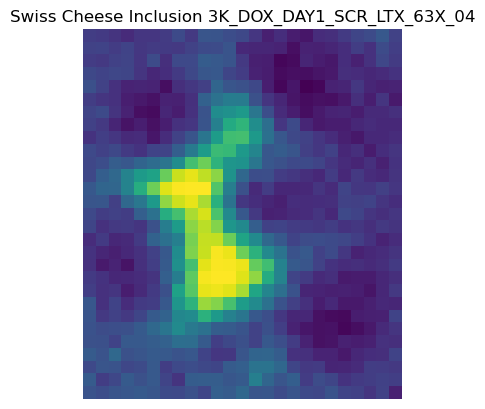

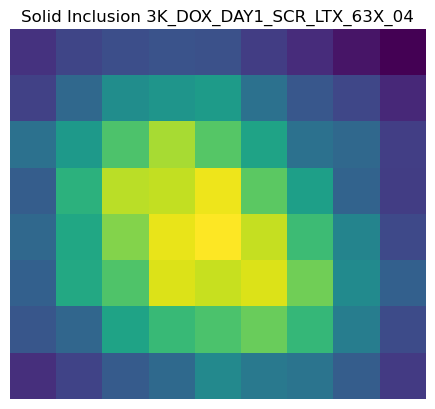

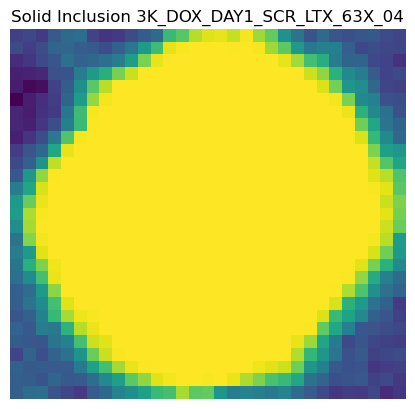

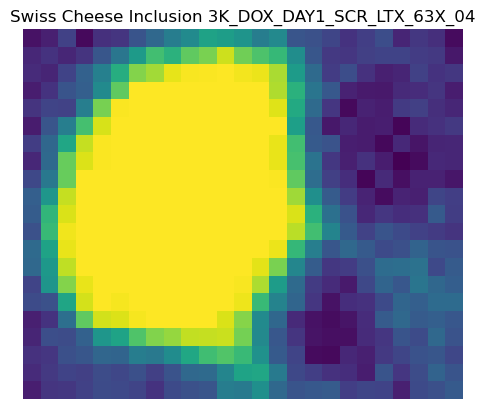

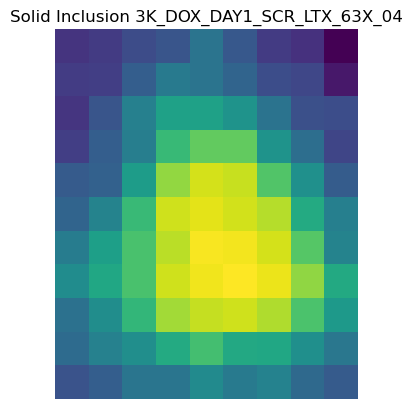

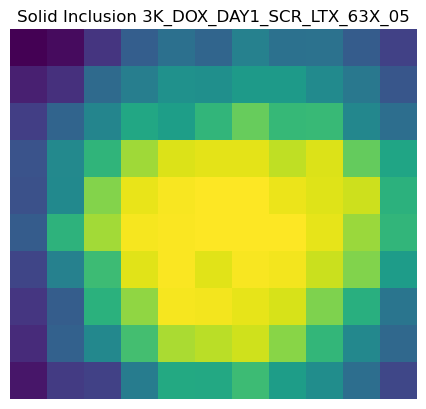

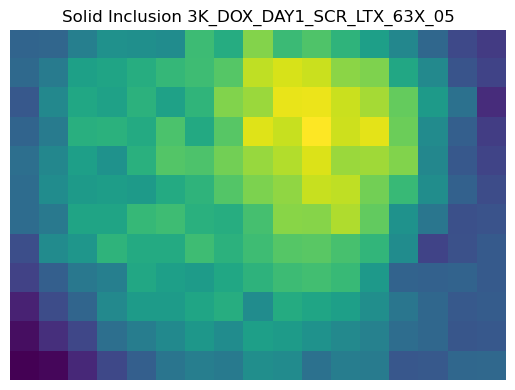

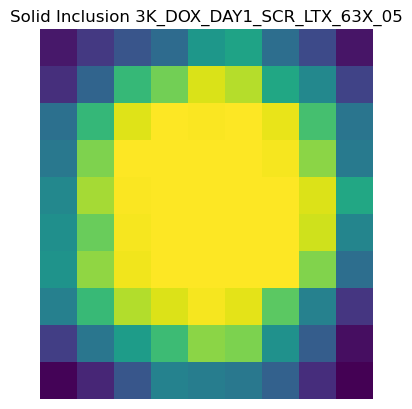

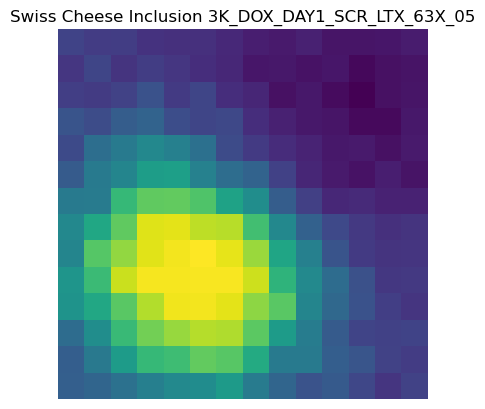

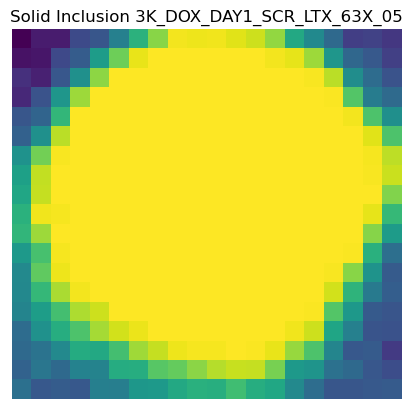

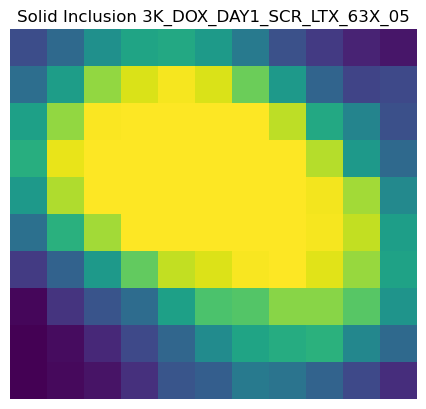

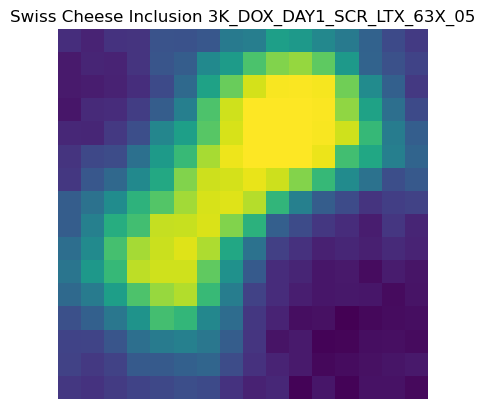

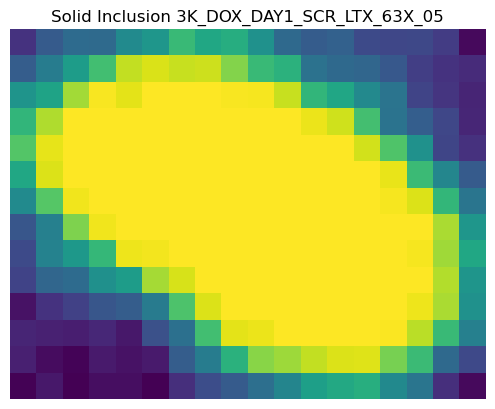

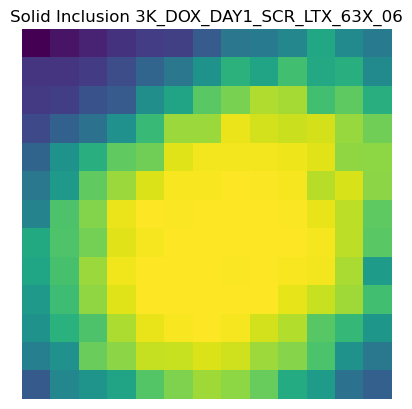

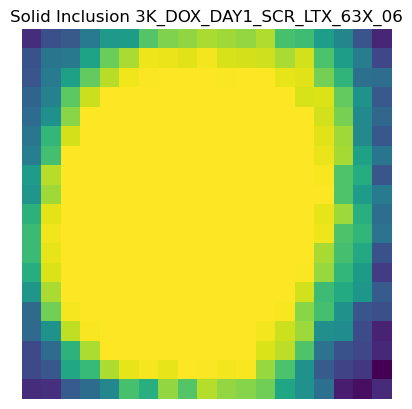

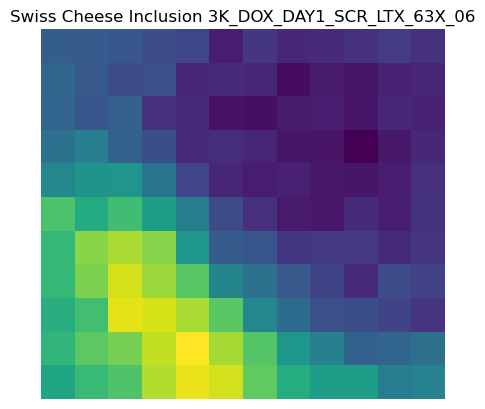

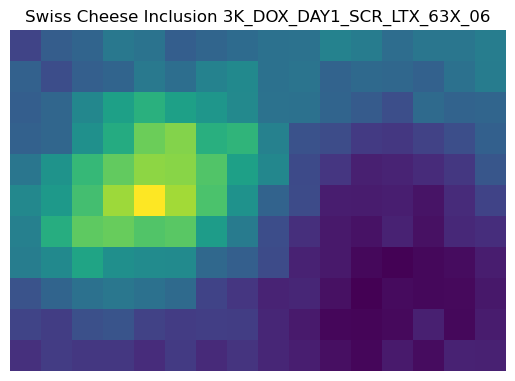

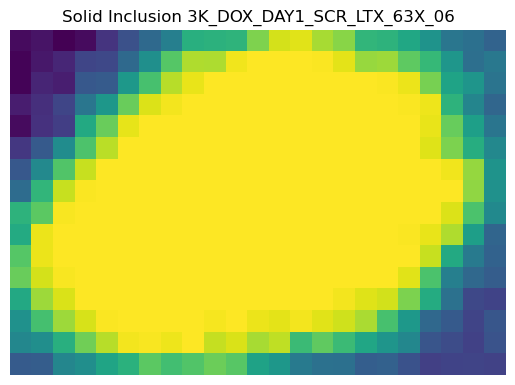

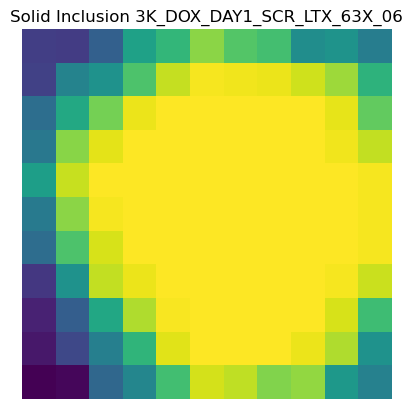

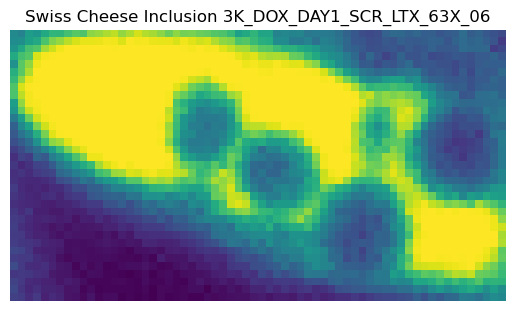

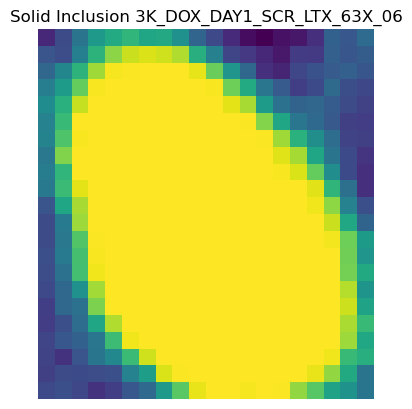

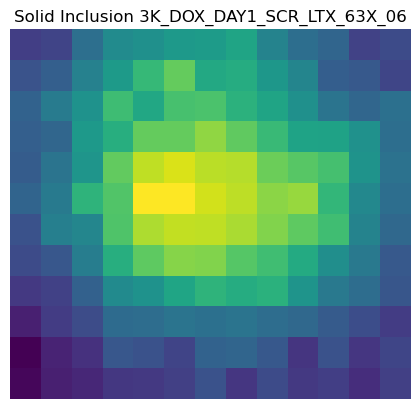

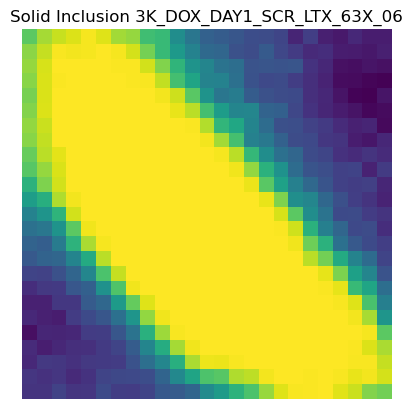

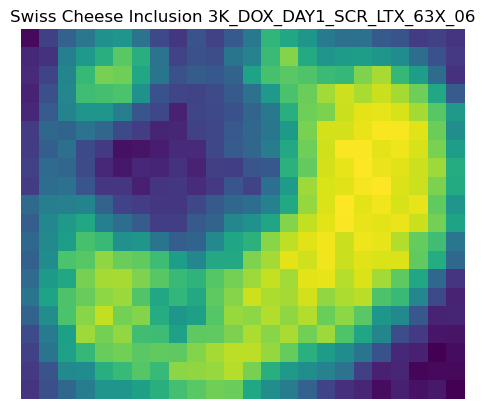

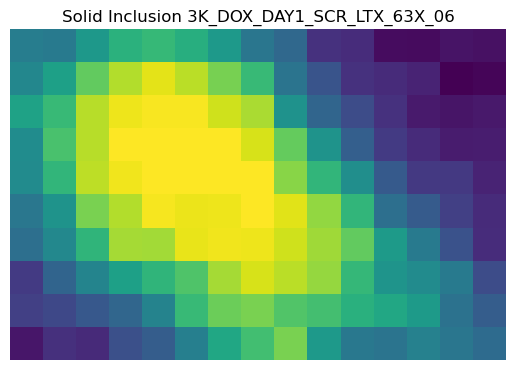

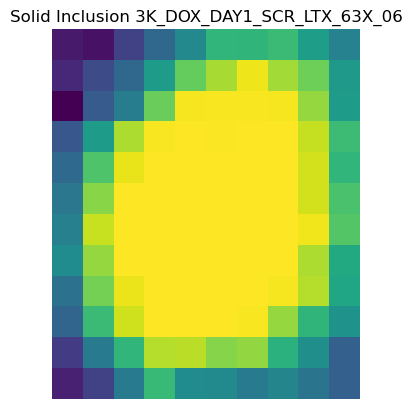

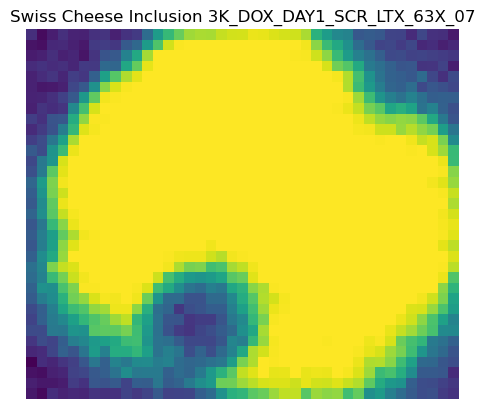

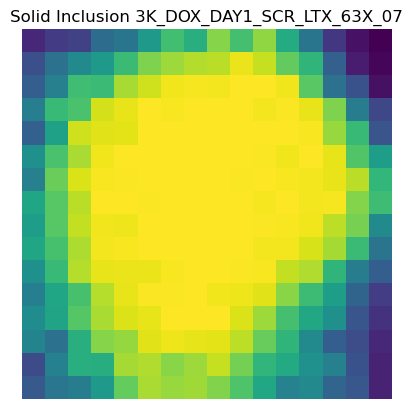

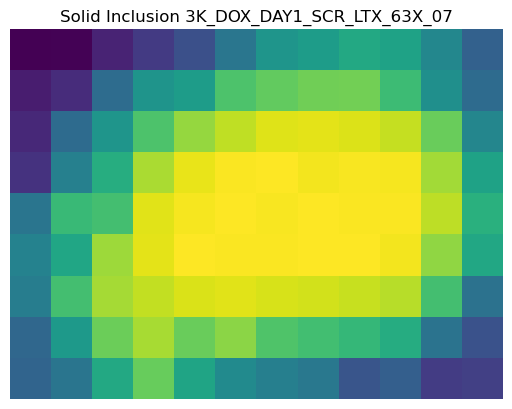

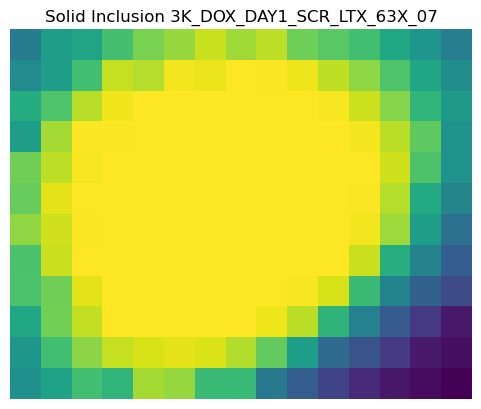

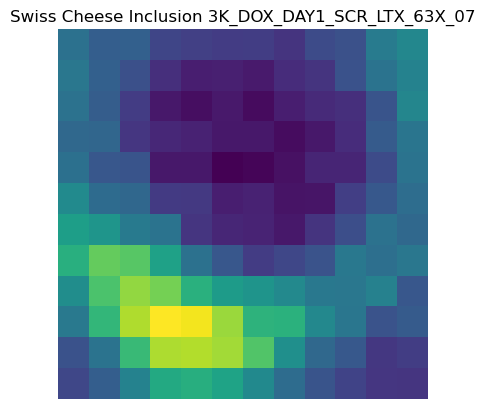

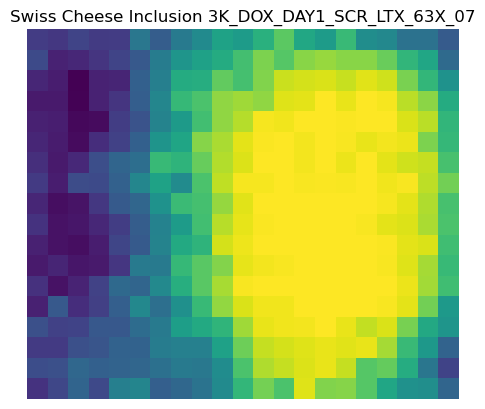

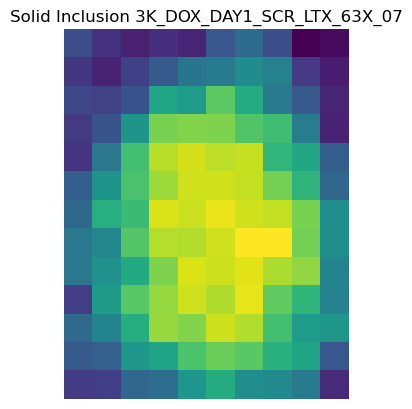

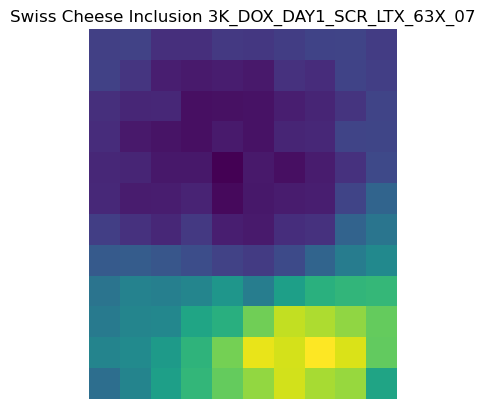

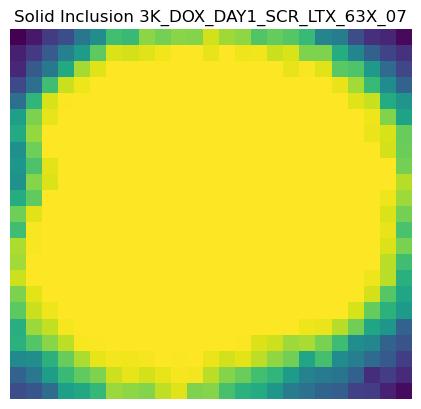

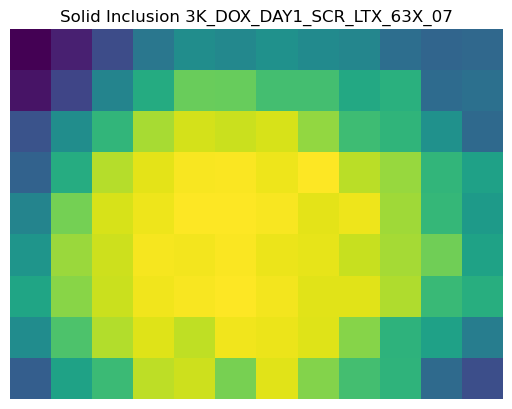

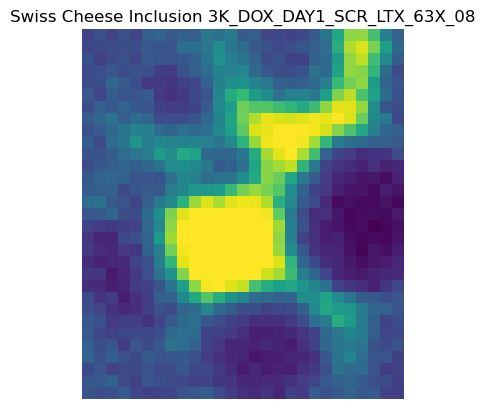

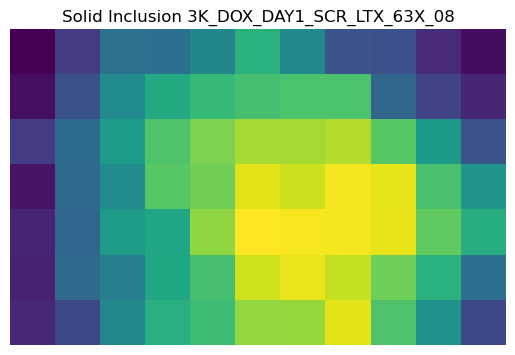

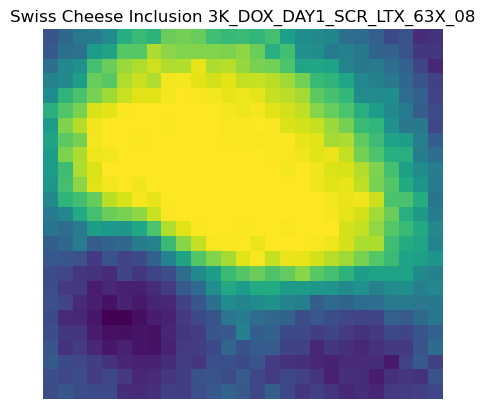

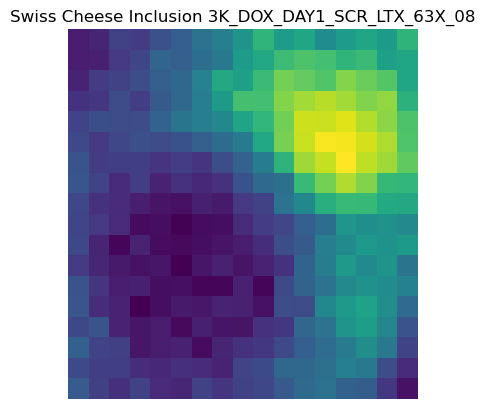

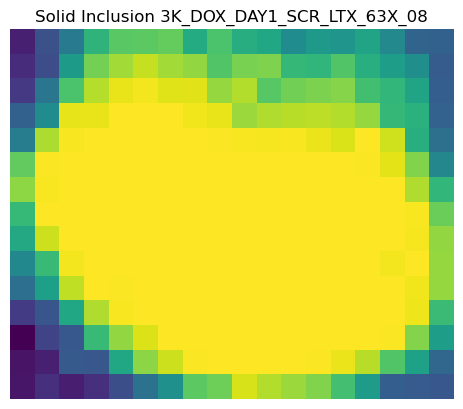

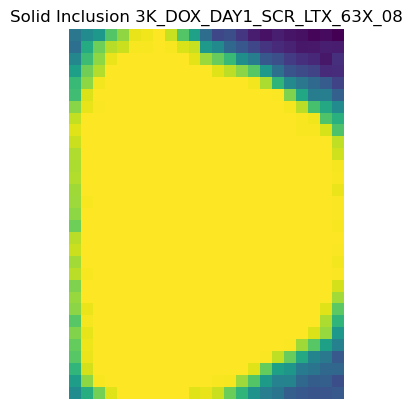

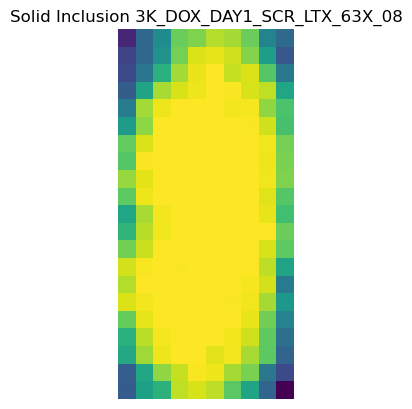

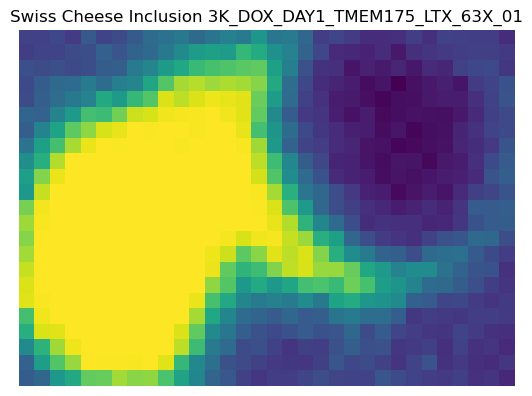

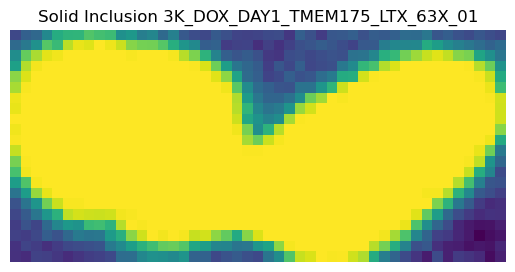

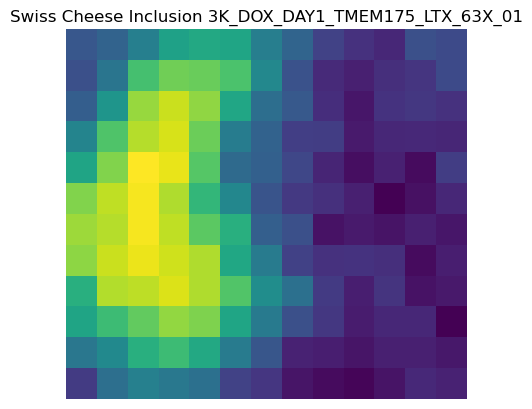

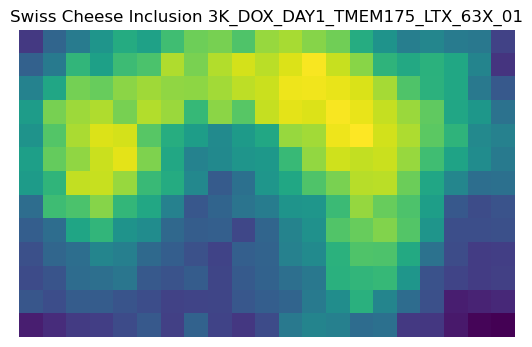

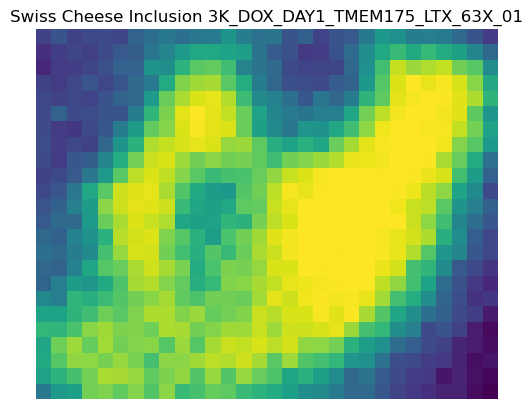

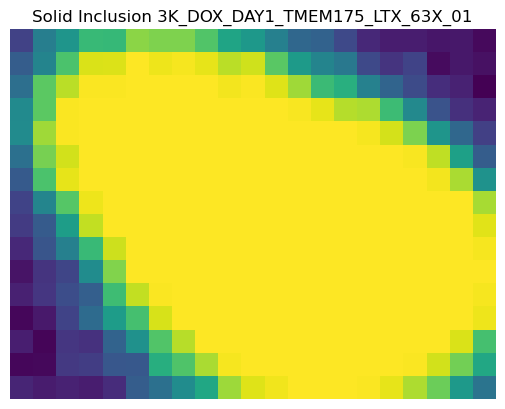

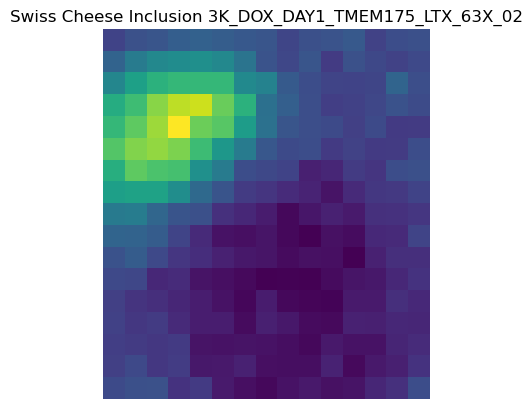

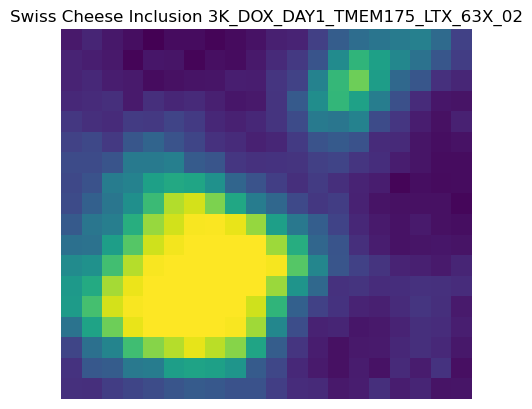

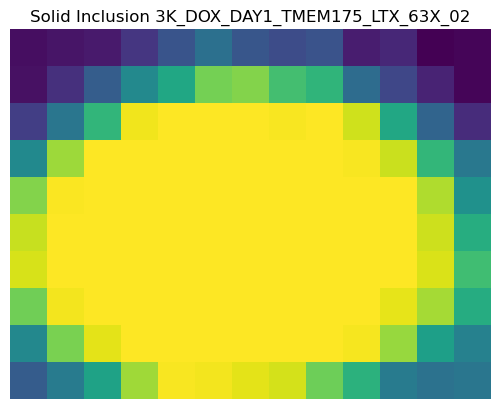

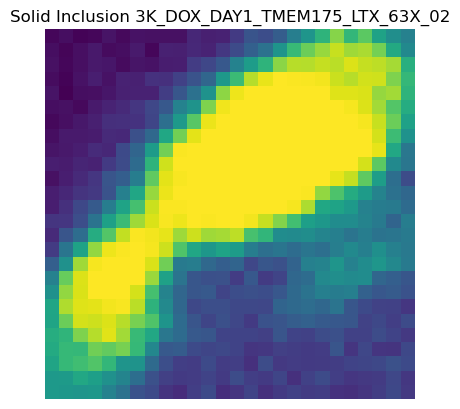

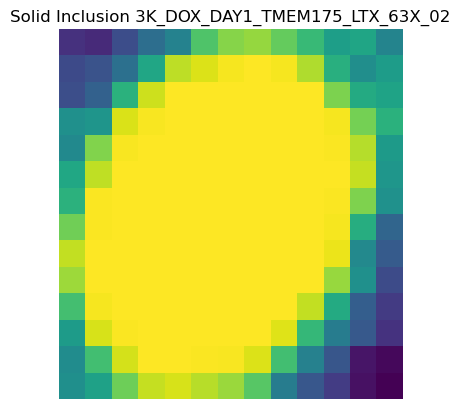

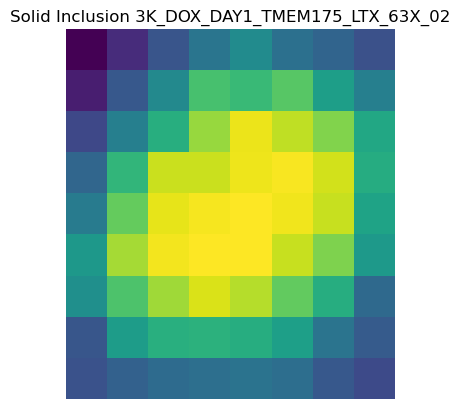

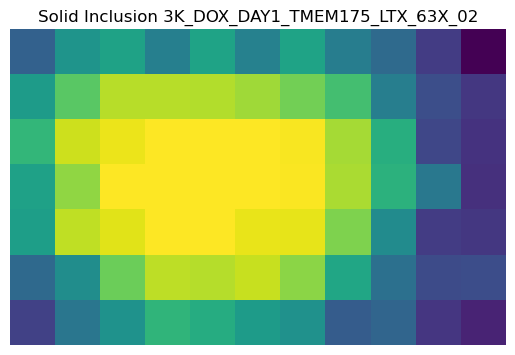

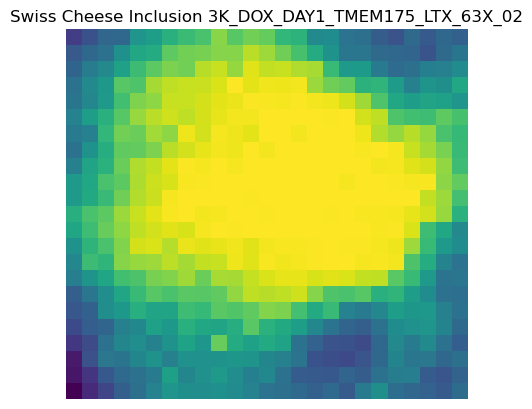

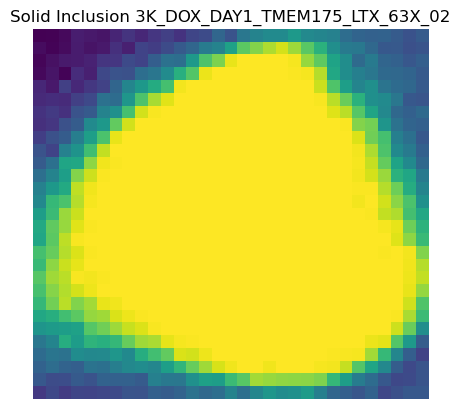

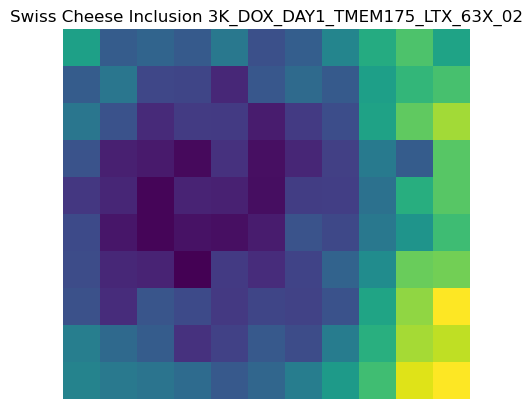

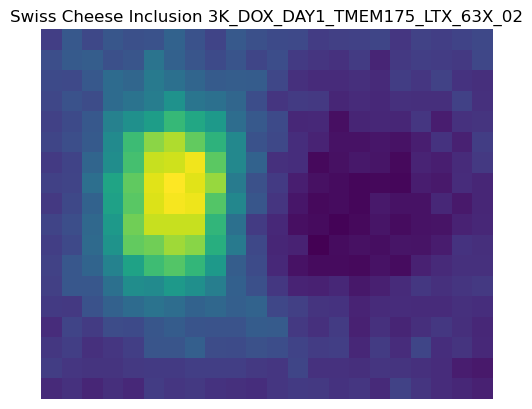

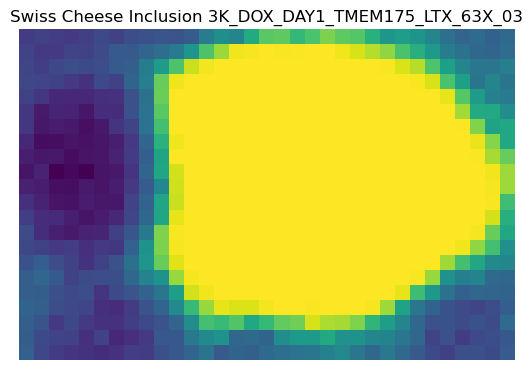

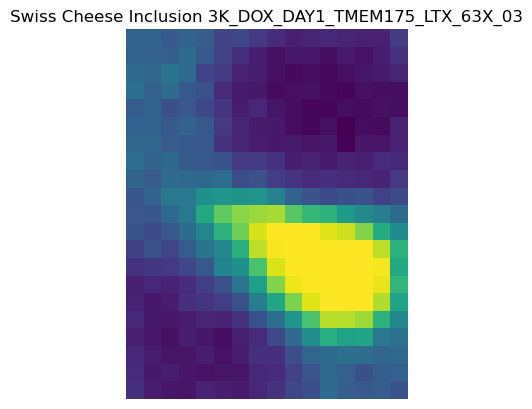

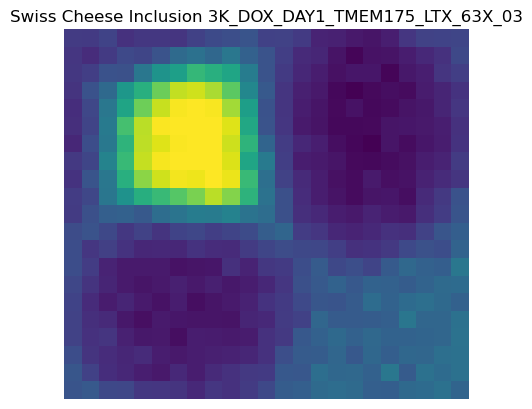

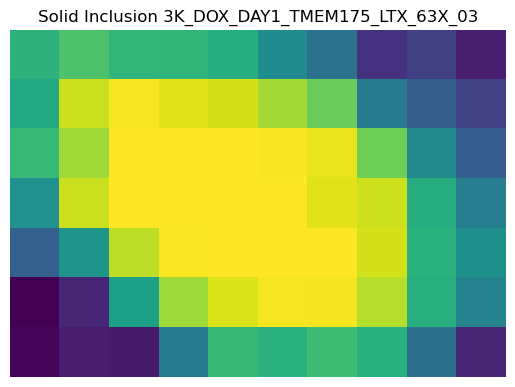

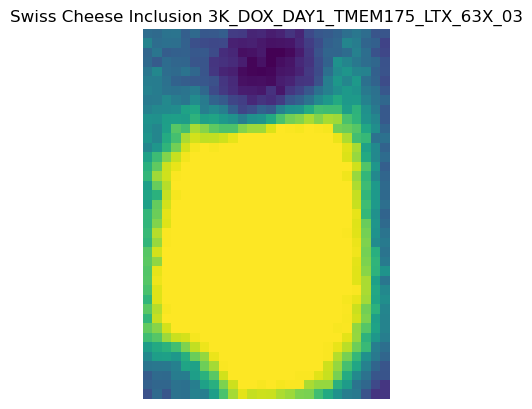

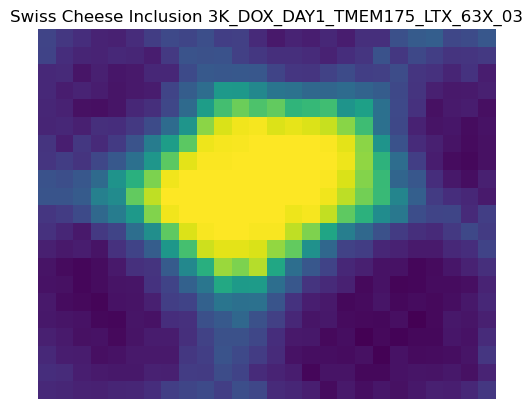

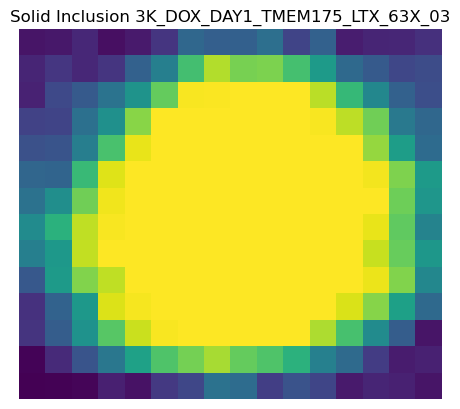

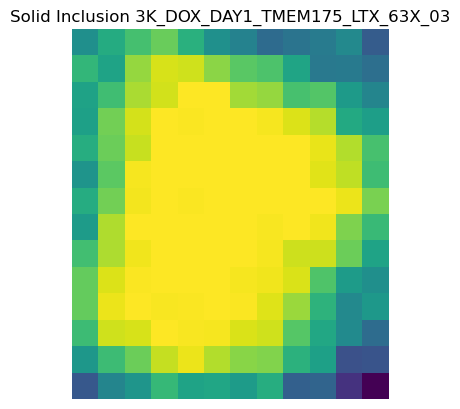

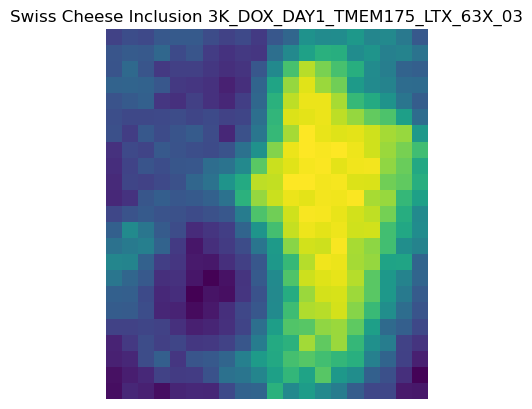

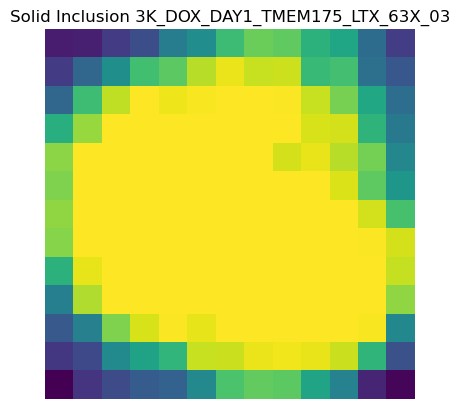

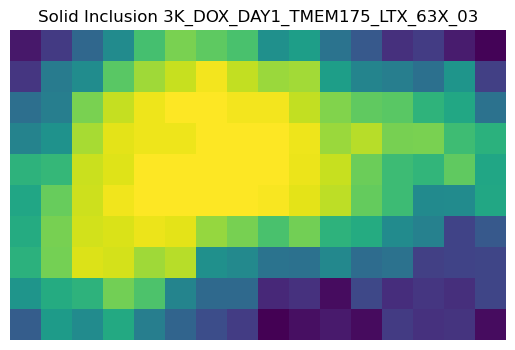

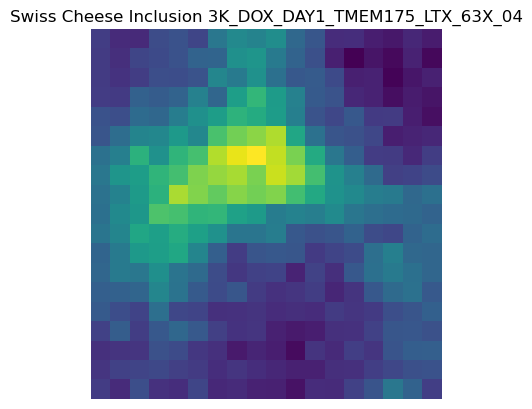

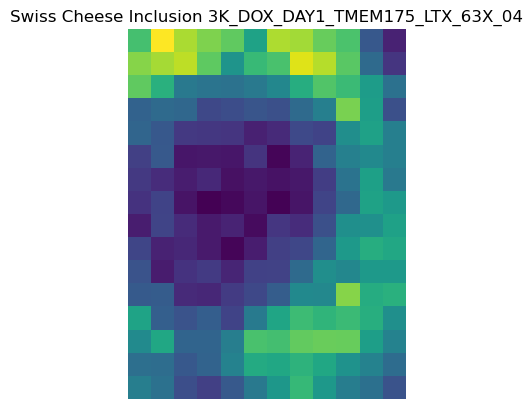

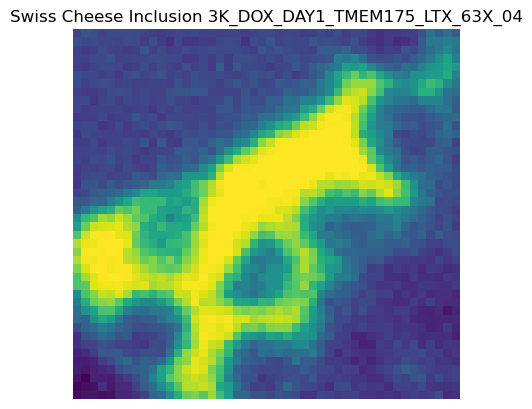

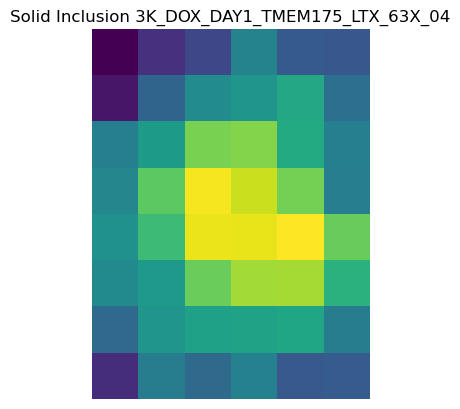

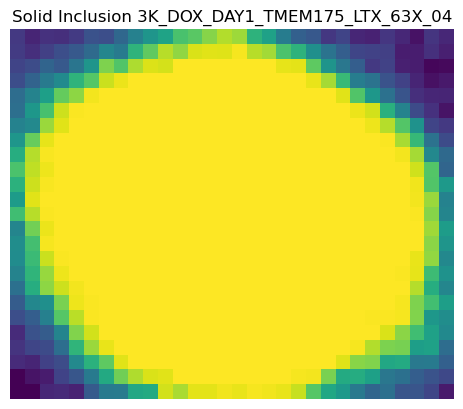

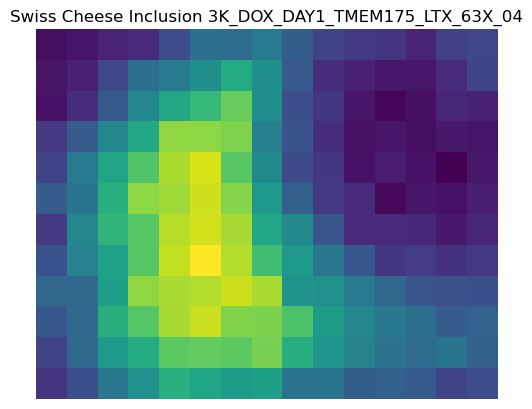

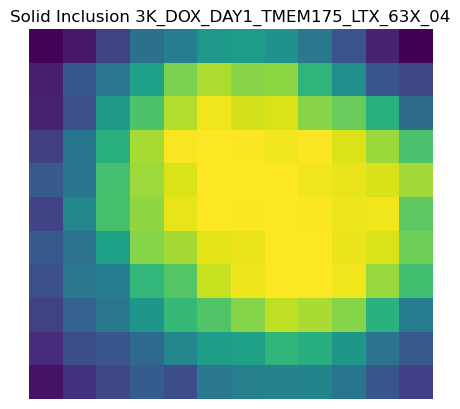

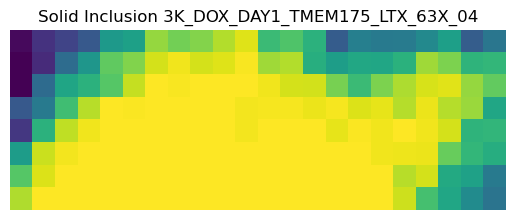

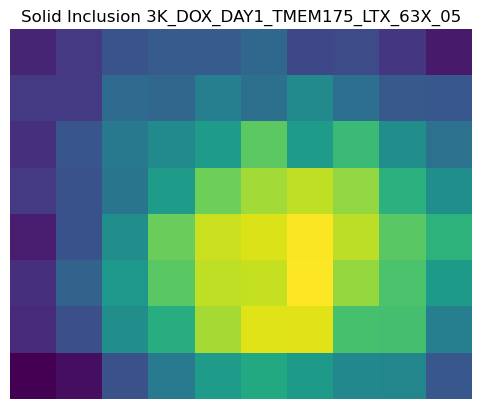

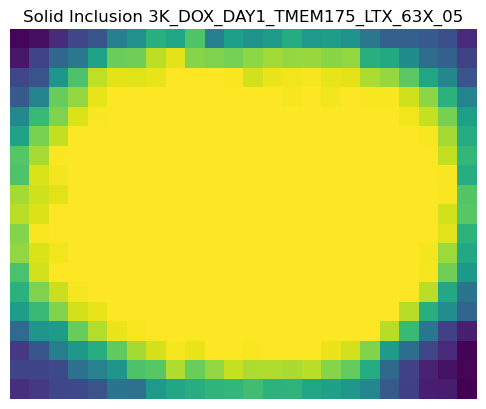

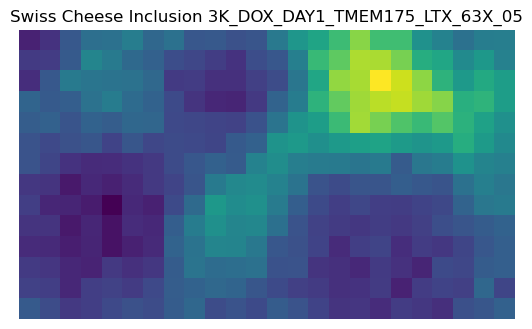

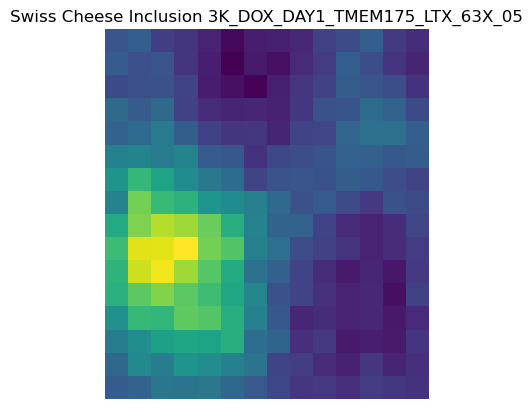

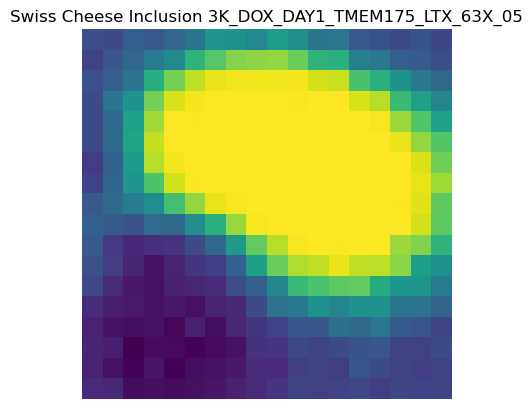

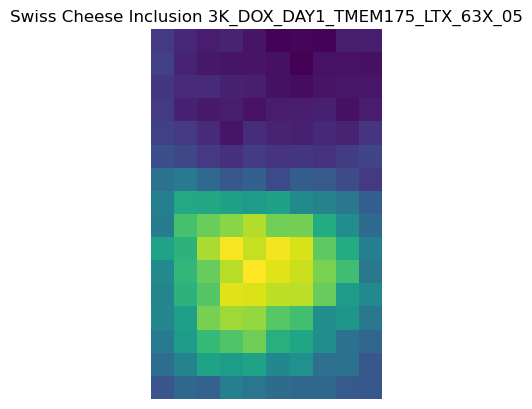

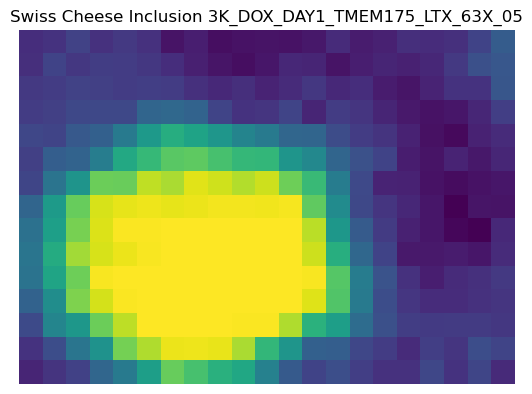

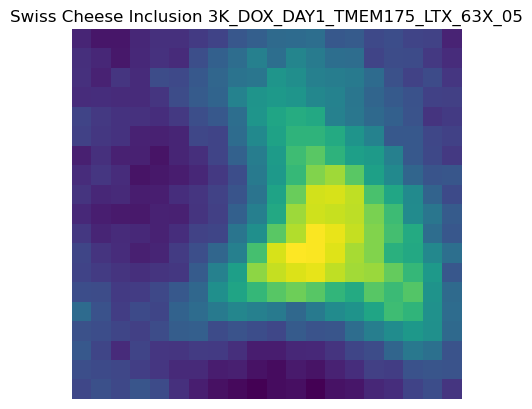

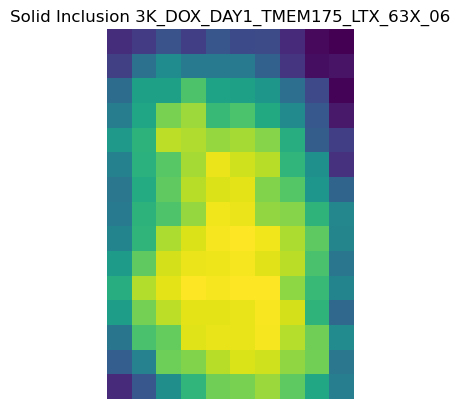

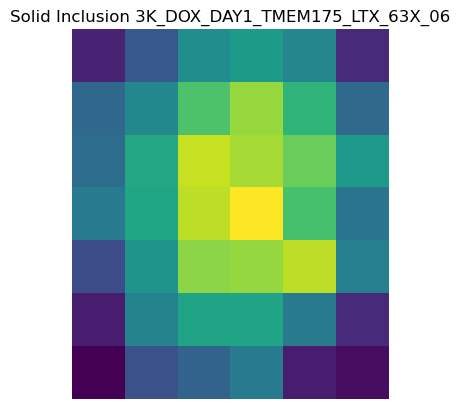

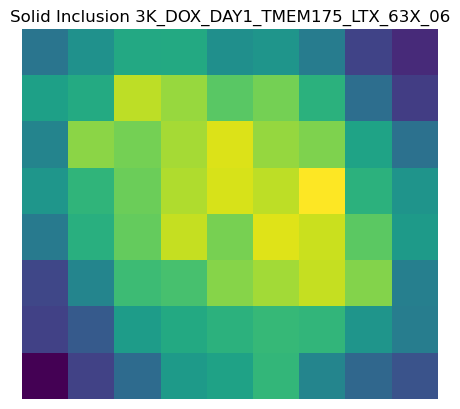

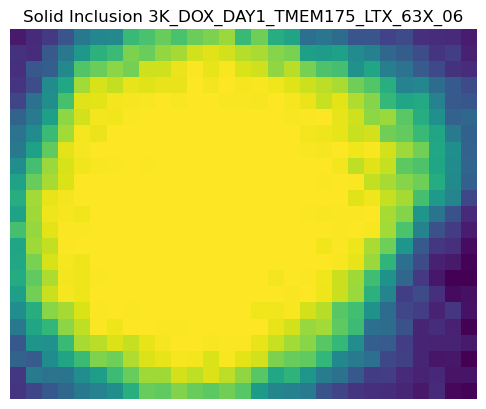

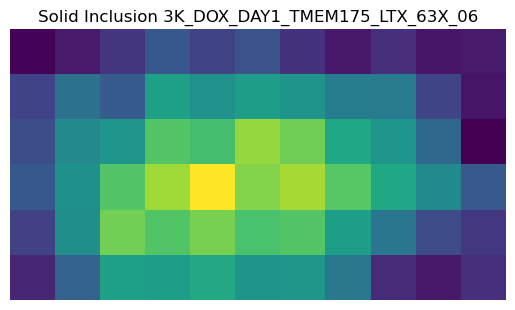

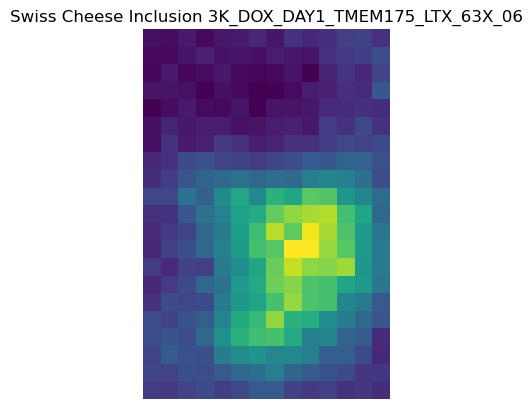

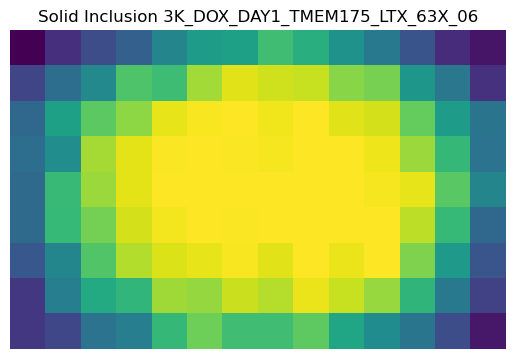

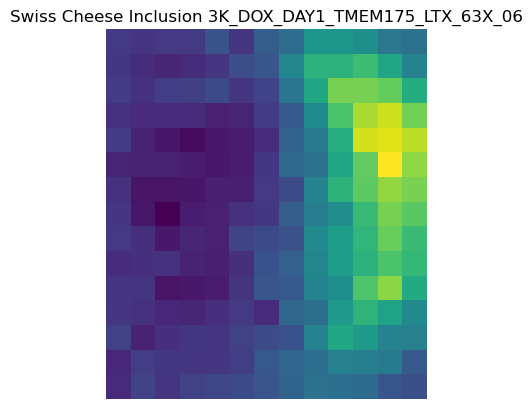

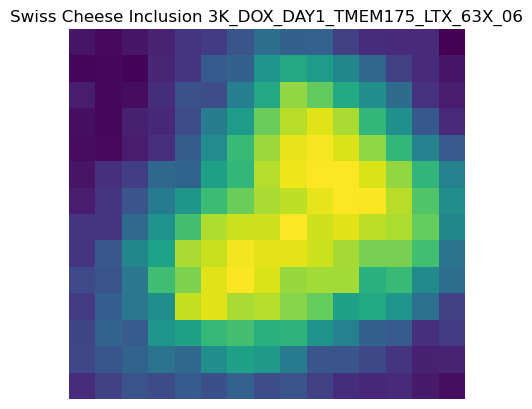

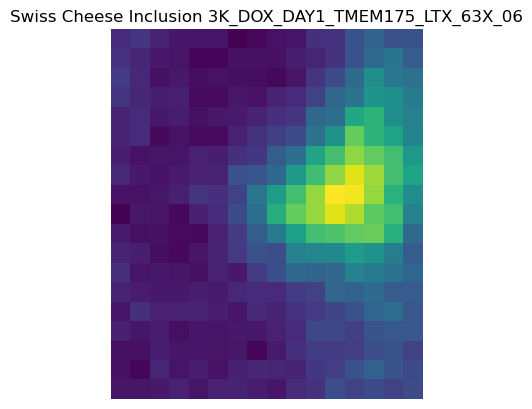

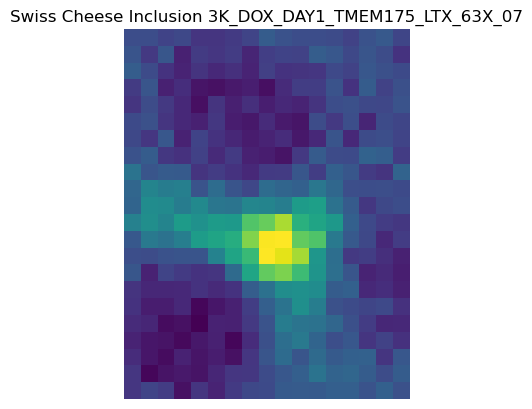

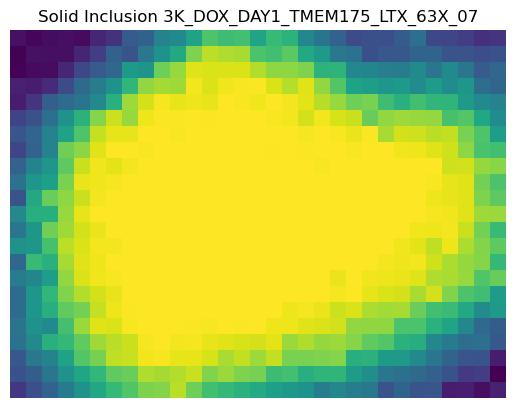

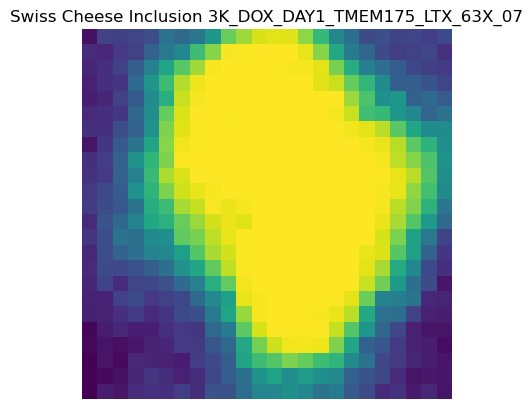

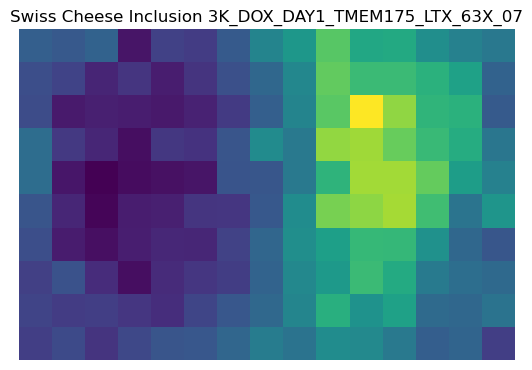

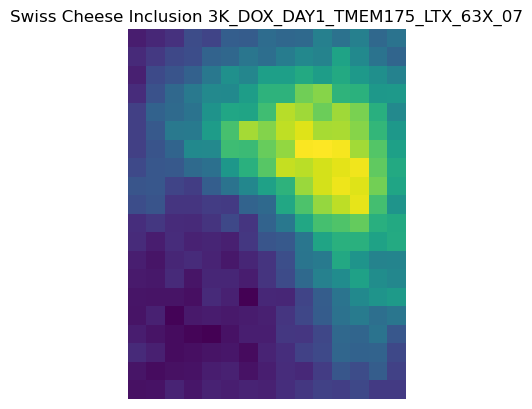

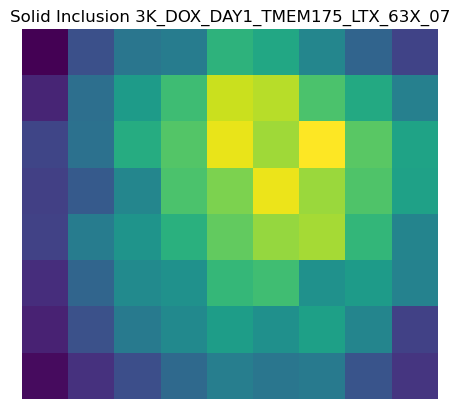

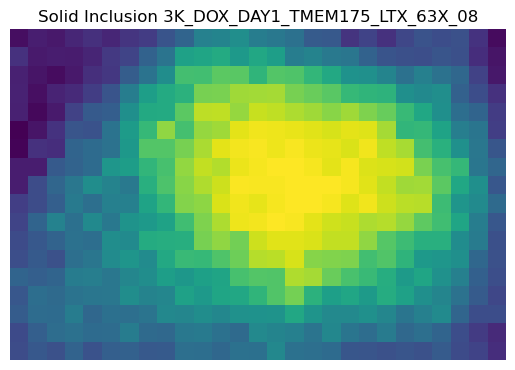

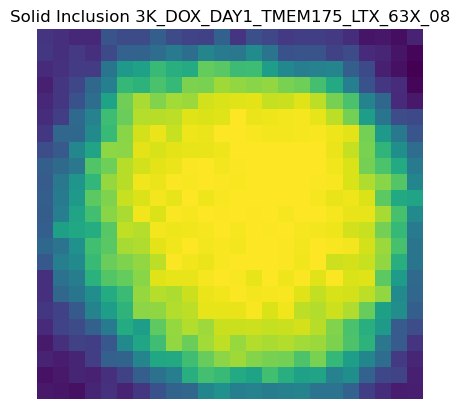

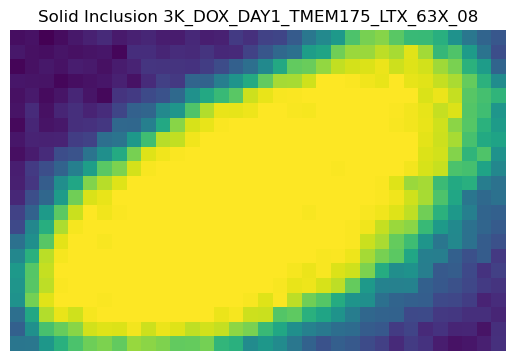

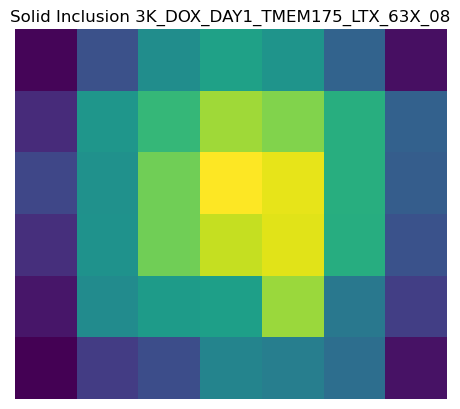

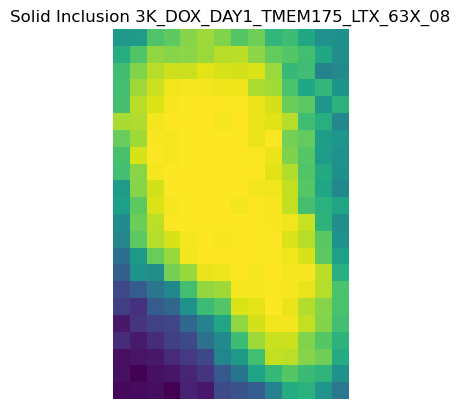

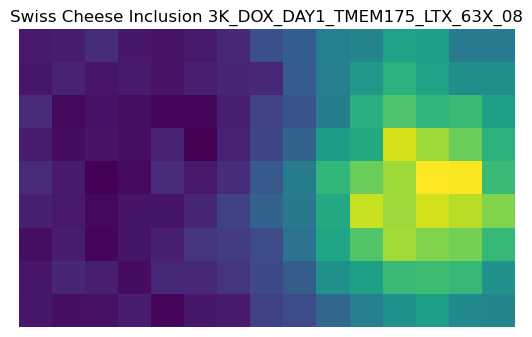

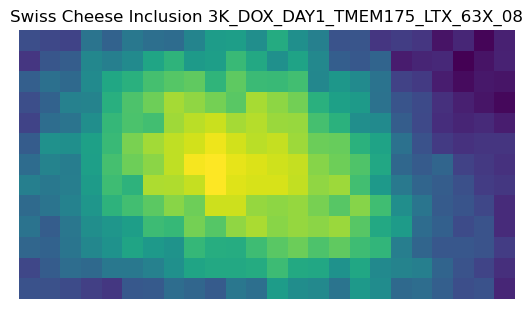

✅ Saved features in: c:\Users\sj1205\Documents\code\Kara-Lab\synuclein_inclusion_biogenesis_2024\image_analysis\TMEM175\features
Swiss Cheese regions: 65
Solid regions: 81


In [5]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()

    # directories
    features_dir = os.path.join(output_dir, "features")
    green_save_dir = os.path.join(output_dir, "png_images")

    # make sure output folders exist
    os.makedirs(features_dir, exist_ok=True)
    os.makedirs(green_save_dir, exist_ok=True)

    swiss_list = []
    solid_list = []

    total_swiss_cheese = 0
    total_solid = 0

    for path in images_to_analyze:
        image = read_image(path)
        file_name = os.path.basename(path)
        image_squeezed = np.squeeze(image)
        green, red = extract_channels(image_squeezed)  # red ignored in analysis

        # analysis returns df_swiss, df_solid
        df_swiss, df_solid = analysis(green, red, file_name)

        if df_swiss is not None and not df_swiss.empty:
            swiss_list.append(df_swiss)
            total_swiss_cheese += len(df_swiss)
        if df_solid is not None and not df_solid.empty:
            solid_list.append(df_solid)
            total_solid += len(df_solid)

    # combine all per-type data
    df_swiss_all = pd.concat(swiss_list, ignore_index=True) if swiss_list else pd.DataFrame()
    df_solid_all = pd.concat(solid_list, ignore_index=True) if solid_list else pd.DataFrame()

    # label column + combined
    if not df_swiss_all.empty:
        df_swiss_all["label"] = "swiss"
    if not df_solid_all.empty:
        df_solid_all["label"] = "solid"

    df_all = pd.concat([df_swiss_all, df_solid_all], ignore_index=True) if (
        not df_swiss_all.empty or not df_solid_all.empty
    ) else pd.DataFrame()

    # save all
    if not df_swiss_all.empty:
        df_swiss_all.to_csv(os.path.join(features_dir, "features_swiss.csv"), index=False)
    if not df_solid_all.empty:
        df_solid_all.to_csv(os.path.join(features_dir, "features_solid.csv"), index=False)
    if not df_all.empty:
        df_all.to_csv(os.path.join(features_dir, "features_all.csv"), index=False)
        try:
            df_all.to_parquet(os.path.join(features_dir, "features_all.parquet"), index=False)
        except Exception:
            pass  # parquet optional if pyarrow not installed

    print(f"✅ Saved features in: {features_dir}")
    print(f"Swiss Cheese regions: {total_swiss_cheese}")
    print(f"Solid regions: {total_solid}")



if __name__ == "__main__":
    image_folder = '91125_images'
    main(image_folder)